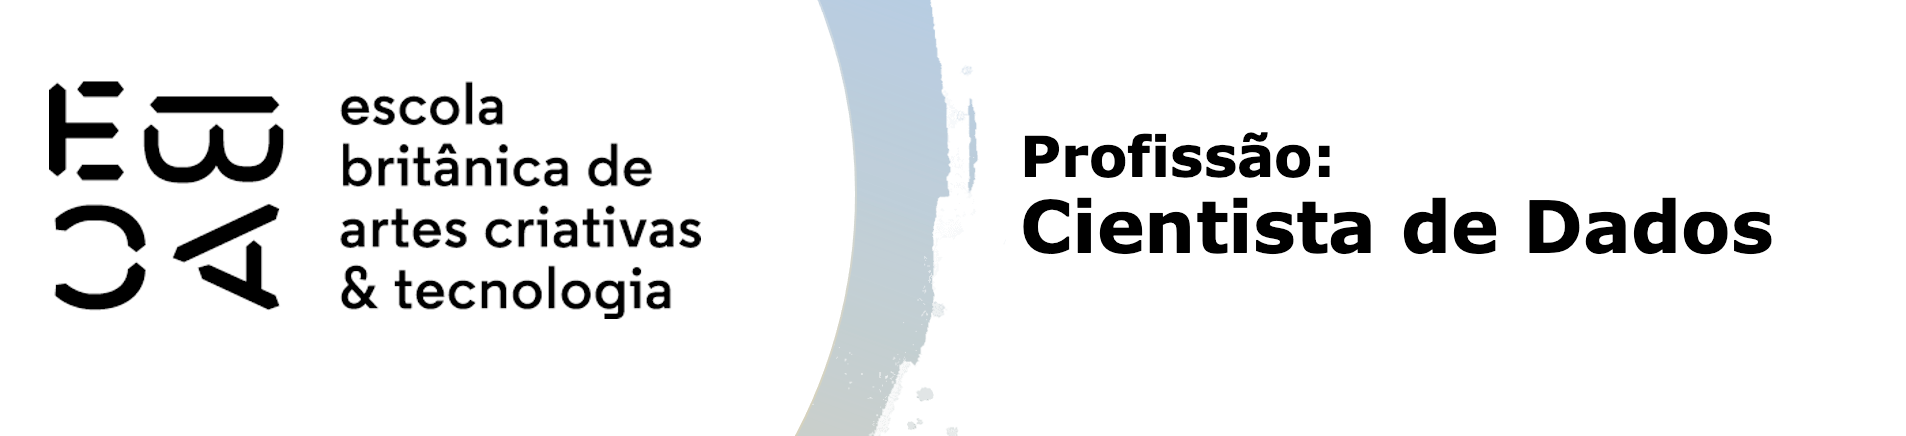

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [34]:
import pandas as pd
import matplotlib as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import OLSInfluence
import scipy.stats as ss 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import warnings
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv('./Dados/previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [4]:
# criando o modelo
df['log_renda'] = np.log(df['renda'])
modelo = smf.ols('log_renda ~ idade + tempo_emprego + qt_pessoas_residencia + C(sexo) + C(posse_de_veiculo) + C(posse_de_imovel) + C(tipo_renda) + C(educacao) + C(estado_civil) + C(tipo_residencia)', data=df).fit()

In [6]:
# Salvando os residuos do modelo
residuos = modelo.resid

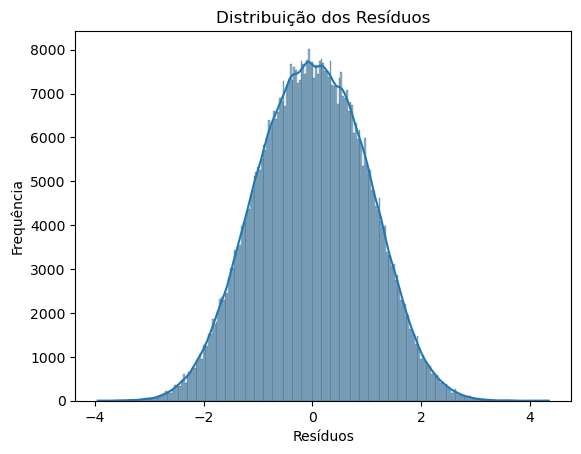

In [7]:
# Grafico dos residuos
sns.histplot(residuos, kde=True)
plt.pyplot.title('Distribuição dos Resíduos')
plt.pyplot.xlabel('Resíduos')
plt.pyplot.ylabel('Frequência')
plt.pyplot.show()

- *Os resíduos do modelo possuiem uma distribuição aparentemente normal*

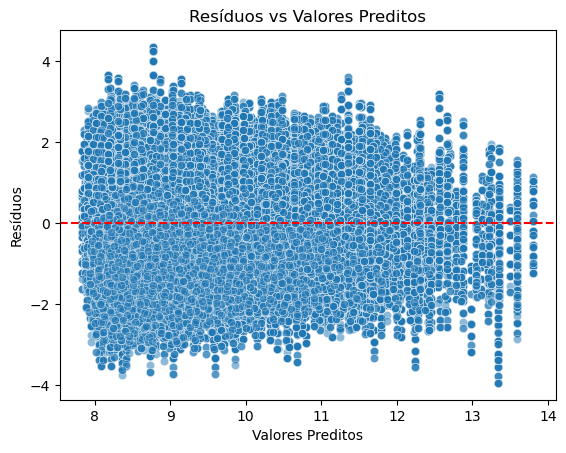

In [8]:
# Gráfico dos resíduos versus os valores preditos
sns.scatterplot(x=modelo.fittedvalues, y=residuos, alpha=0.5)
plt.pyplot.axhline(0, color='red', linestyle='--')
plt.pyplot.title('Resíduos vs Valores Preditos')
plt.pyplot.xlabel('Valores Preditos')
plt.pyplot.ylabel('Resíduos')
plt.pyplot.show()

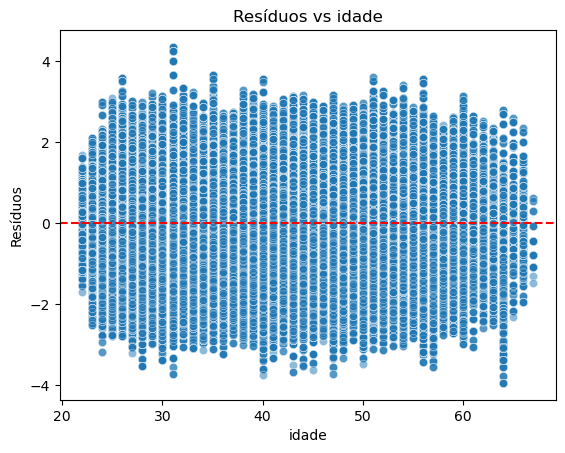

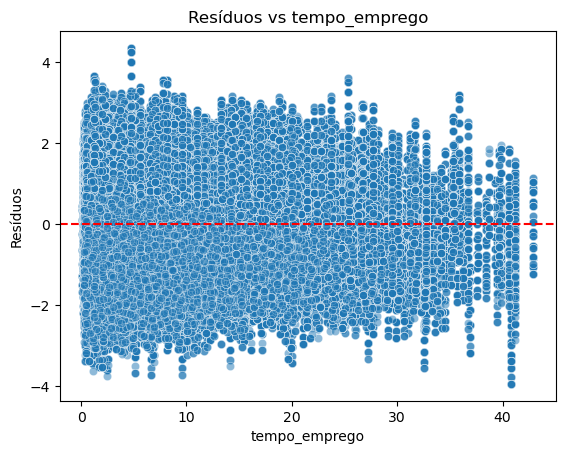

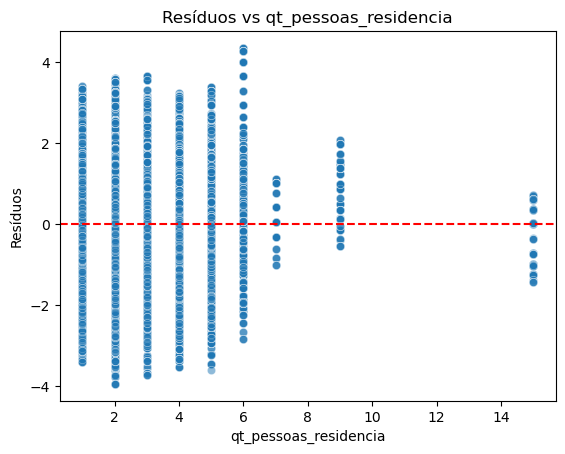

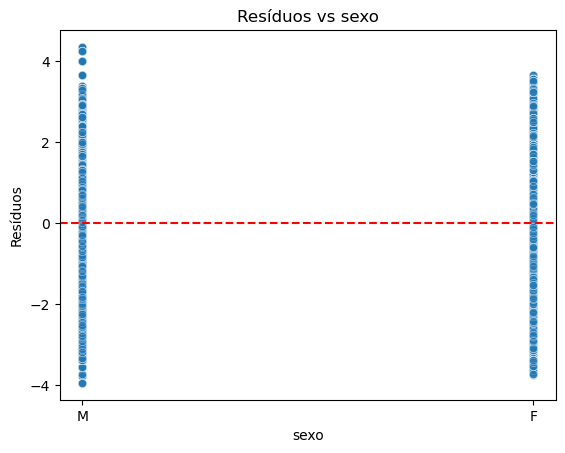

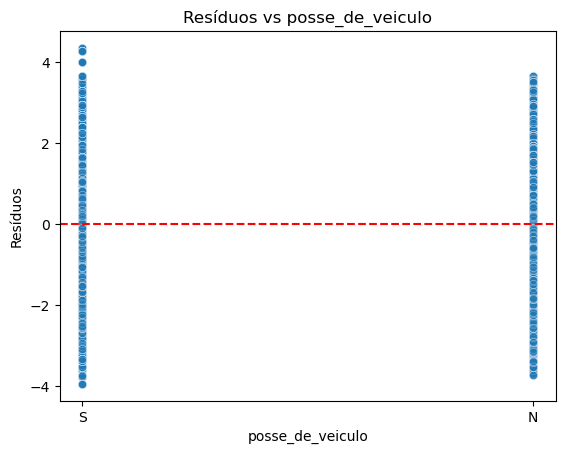

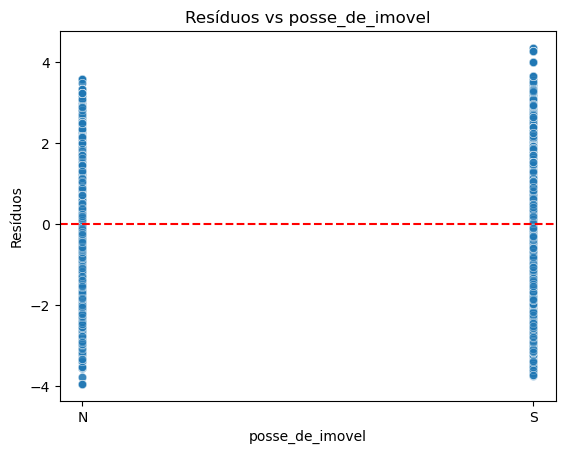

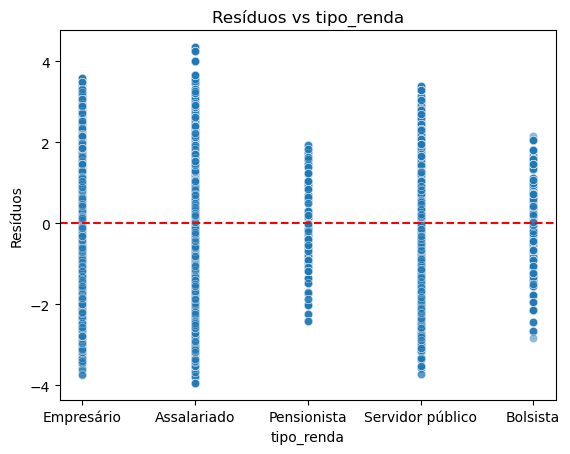

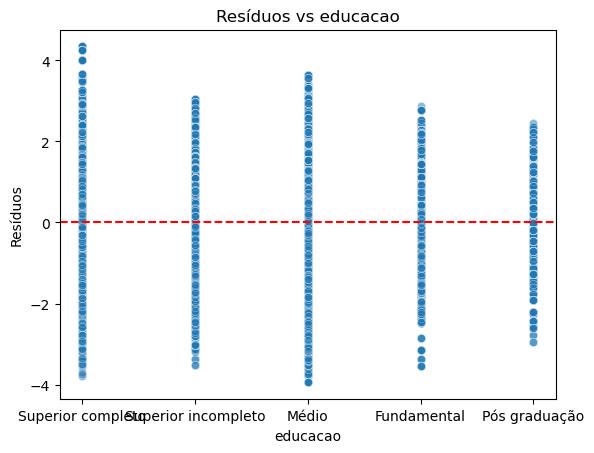

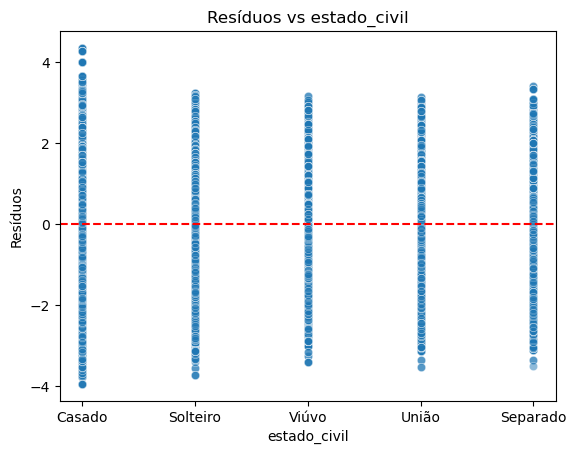

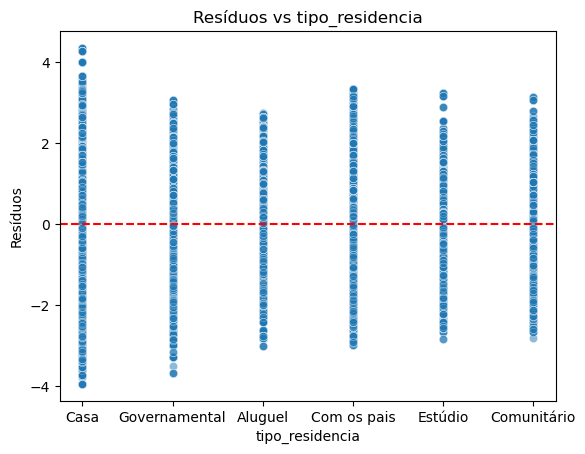

In [9]:
# Gráficos dos resíduos versus cada uma das variáveis do modelo
variaveis = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'sexo', 'posse_de_veiculo', 
             'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

for var in variaveis:
    sns.scatterplot(x=df[var], y=residuos, alpha=0.5)
    plt.pyplot.axhline(0, color='red', linestyle='--')
    plt.pyplot.title(f'Resíduos vs {var}')
    plt.pyplot.xlabel(var)
    plt.pyplot.ylabel('Resíduos')
    plt.pyplot.show()

- *Os graficos de residuos vs cada uma das variaveis também não mostrou padrões evidentes, o que tambem sugere independencia.*

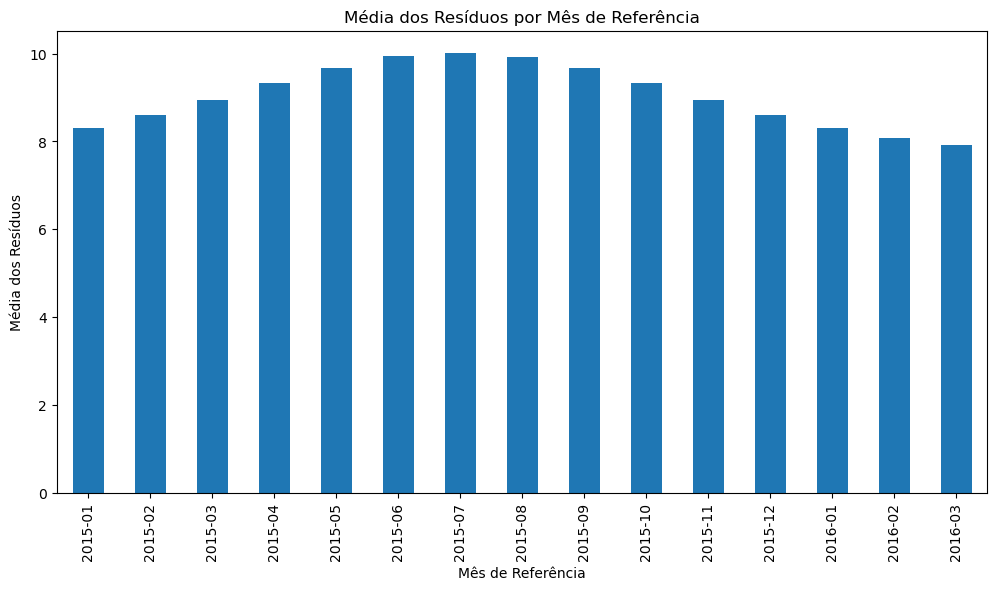

In [11]:
# Avaliação do valor médio dos resíduos em relação ao mês de referência
df['mes_referencia'] = pd.to_datetime(df['data_ref']).dt.to_period('M')
residuos_por_mes = df.groupby('mes_referencia')['log_renda'].mean()

residuos_por_mes.plot(kind='bar', figsize=(12, 6))
plt.pyplot.title('Média dos Resíduos por Mês de Referência')
plt.pyplot.xlabel('Mês de Referência')
plt.pyplot.ylabel('Média dos Resíduos')
plt.pyplot.show()

In [14]:
df.shape

(750000, 16)

- *A média dos residuos por mês de referencia não apresenta uma variação muito grando, o que indica que não há relação significativa com o tempo.*

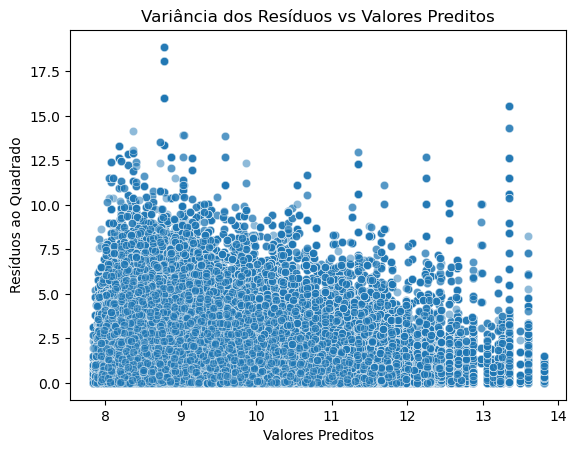

In [12]:
# Gráfico da variância dos resíduos em relação aos valores previstos
sns.scatterplot(x=modelo.fittedvalues, y=residuos**2, alpha=0.5)
plt.pyplot.title('Variância dos Resíduos vs Valores Preditos')
plt.pyplot.xlabel('Valores Preditos')
plt.pyplot.ylabel('Resíduos ao Quadrado')
plt.pyplot.show()

- *O grafico da variancia dos resíduos em relação aos valores preditos também não apresenta um padrão claro de aumento ou diminuição. A variancia parece ser constante.*

- *As suposições basicas do mdelo parecem estar atendidas. Os desvios observados são pequenos e não devem ter um grande impacto no desempenho do modelo.*

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [21]:
# calculando student_resid
influencia = OLSInfluence(modelo)
st = influencia.resid_studentized_internal

In [22]:
# idetificando os outliers
outliers = abs(st) > 3
print(f"Numero de outliers: {outliers.sum()}")

Numero de outliers: 721


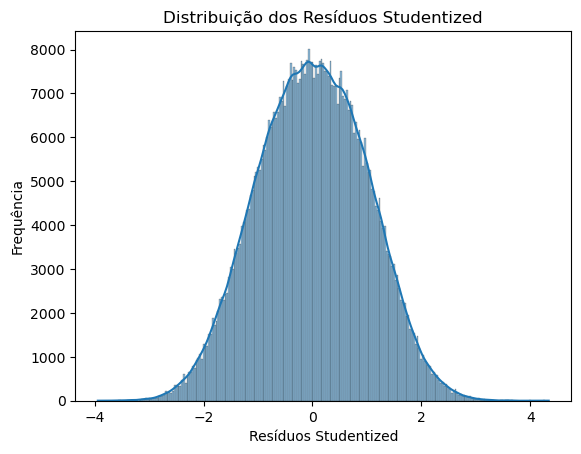

In [27]:
sns.histplot(st, kde=True)
plt.pyplot.title('Distribuição dos Resíduos Studentized')
plt.pyplot.xlabel('Resíduos Studentized')
plt.pyplot.ylabel('Frequência')
plt.pyplot.show()

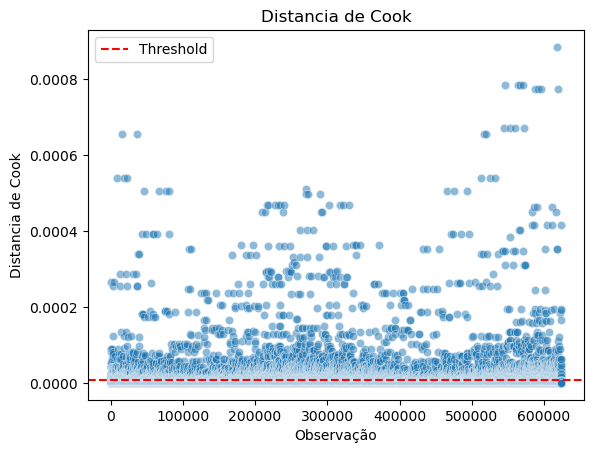

In [32]:
# avaliando pontos influentes
cooks_d = influencia.cooks_distance[0]
sns.scatterplot(x=range(len(cooks_d)), y=cooks_d, alpha=0.5)
plt.pyplot.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold')
plt.pyplot.title("Distancia de Cook")
plt.pyplot.xlabel('Observação')
plt.pyplot.ylabel("Distancia de Cook")
plt.pyplot.legend()
plt.pyplot.show()

In [33]:
pontos = cooks_d > (4 / len(cooks_d))
print(f"Numeor de pontos influentes: {pontos.sum()}")

Numeor de pontos influentes: 25310


- *Foram encontrados alguns outliers, mas são poucos em comparação com o tamanho do dataset.*
- *Com relação aos poontos influentes, a analise indicou que há alguns pontos que podem ter um impacto desproporcional no modelo.*

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

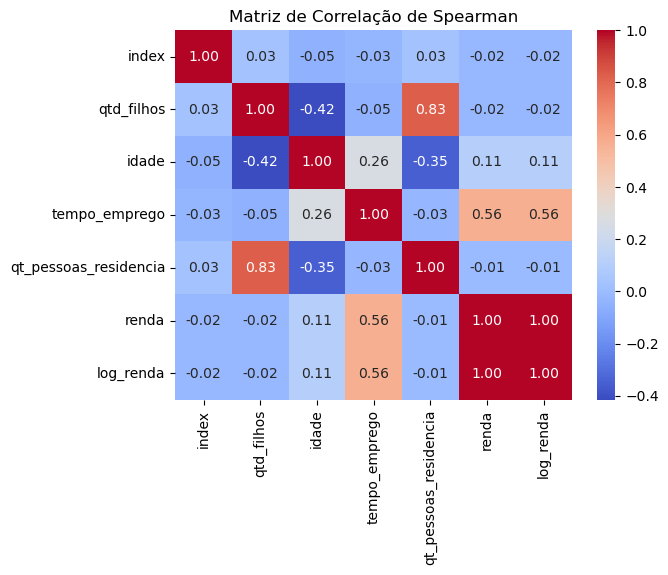

In [ ]:
# Matriz de correlação de Spearman
numericas = df.select_dtypes(include=['float64', 'int64'])
spearman = numericas.corr(method='spearman')
sns.heatmap(spearman, annot=True, fmt=".2f", cmap="coolwarm")
plt.pyplot.title("Matriz de Correlação de Spearman")
plt.pyplot.show()

In [40]:
# Calculando o VIF
X = df[['idade', 'tempo_emprego', 'qt_pessoas_residencia']]

# Substituindo faltantes
X['tempo_emprego'] = X['tempo_emprego'].fillna(X['tempo_emprego'].mean())

X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variável"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                Variável        VIF
0                  const  32.436167
1                  idade   1.204409
2          tempo_emprego   1.068187
3  qt_pessoas_residencia   1.132695


- *Na matriz de correlação de Spearman a unica corelação alta foi entre a quantidade de filhos e pessas na residencia, mas ainda assim, abaixo de 0.8.*

- *Todos os valore do VIF foram abaixo de 5, indicando que não há multicolinearidade significativa.*

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado

In [ ]:
# Removendo outliers e pontos influentes
aligned_outliers = outliers.reindex(df.index, fill_value=False)
aligned_pontos = pontos.reindex(df.index, fill_value=False)
df_ajustado = df[~aligned_outliers & ~aligned_pontos]

Modelo Original:
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                 2.064e+04
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:05:49   Log-Likelihood:            -8.8655e+05
No. Observations:              624240   AIC:                         1.773e+06
Df Residuals:                  624216   BIC:                         1.773e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [43]:
# Criando o modelo ajustado
modelo_ajustado = smf.ols(
    'log_renda ~ idade + tempo_emprego + qt_pessoas_residencia + C(sexo) + C(posse_de_veiculo) + C(posse_de_imovel) + C(tipo_renda) + C(educacao) + C(estado_civil) + C(tipo_residencia)',
    data=df_ajustado
).fit()

In [44]:
print("Modelo Original:")
print(modelo.summary())

Modelo Original:
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                 2.064e+04
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:06:48   Log-Likelihood:            -8.8655e+05
No. Observations:              624240   AIC:                         1.773e+06
Df Residuals:                  624216   BIC:                         1.773e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [45]:
print("\nModelo Ajustado:")
print(modelo_ajustado.summary())


Modelo Ajustado:
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                 2.193e+04
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:06:57   Log-Likelihood:            -8.1482e+05
No. Observations:              598812   AIC:                         1.630e+06
Df Residuals:                  598788   BIC:                         1.630e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------